## Chapter 3: Linear Regression - Lab

In [7]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Specific to the textbook ISLP
from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly

#### 3.6.2 Simple Linear Regression

We will use the Boston housing data set, which is contained in the `ISLP` package. The Boston dataset records `medv` (median house value) for 506 neighborhoods around Boston. We will build a regression model to predict medv using 13 predictors such as `rmvar` (average number of rooms per
house), `age` (proportion of owner-occupied units built prior to 1940), and `lstat` (percent of households with low socioeconomic status). 

In [8]:
Boston = load_data('Boston')
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

We fit a simple linear regression model using `sm.OLS()`, with `medv` as the response and `lstat` as the only predictor.

In [17]:
X = pd.DataFrame({
    'intercept': np.ones(Boston.shape[0]),
    'lstat': Boston['lstat']
})

y = Boston['medv']

In [16]:
X

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33
...,...,...
501,1.0,9.67
502,1.0,9.08
503,1.0,5.64
504,1.0,6.48


In [18]:
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: medv, Length: 506, dtype: float64

In [19]:
# Fit the model
model = sm.OLS(y, X)
results = model.fit()

In [24]:
# Shw the summary of the parameter estimates, their standard errors, t-statistics and p-values
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           5.08e-88
Time:                        11:33:52   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
design = MS(['lstat'])
design = design.fit(Boston)
X = design.transform(Boston)

In [29]:
X

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33
...,...,...
501,1.0,9.67
502,1.0,9.08
503,1.0,5.64
504,1.0,6.48


In [31]:
design = MS(['lstat'])
X = design.fit_transform(Boston)
X

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33
...,...,...
501,1.0,9.67
502,1.0,9.08
503,1.0,5.64
504,1.0,6.48


In [35]:
# Retrieve the fitted coefficients as the params attribute of results
results.params

intercept    34.553841
lstat        -0.950049
dtype: float64

We can use `get_prediction()` to obtain predictions. First, re produce a new data frame containing the values of `lstat` at which we wish to make predictions:

In [36]:
new_df = pd.DataFrame({'lstat': [5, 10, 15]})
newX = design.transform(new_df)
newX

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [37]:
# Compute predictions at newX:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

We can produce _confidence intervals_ by setting `obs=False`.

If you set `obs=False`, the confidence intervals will be computed for hypothetical or out-of-sample data points. This means you can use the trained model to make predictions for new data points that were not part of the original dataset. The confidence intervals will represent the uncertainty around predictions for these new data points.

In [39]:
In [18]: new_predictions.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

Prediction intervals are computing by setting `obs=True`.

If you set `obs=True`, the confidence intervals will be computed for the observed data points that were used to fit the model. In other words, the confidence intervals will represent the uncertainty around the predicted values for the same data points that were used during the model training.

In [38]:
# Confidence intervals for predicted values:
new_predictions.conf_int(obs=True, alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

As expected, the prediction intervals are centered around the same points as the confidence intervals, although the prediction intervals are much wider.

In [41]:
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)


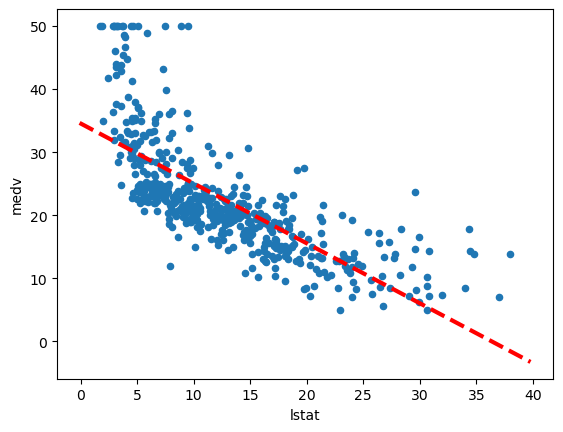

In [42]:
ax = Boston.plot.scatter('lstat', 'medv')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

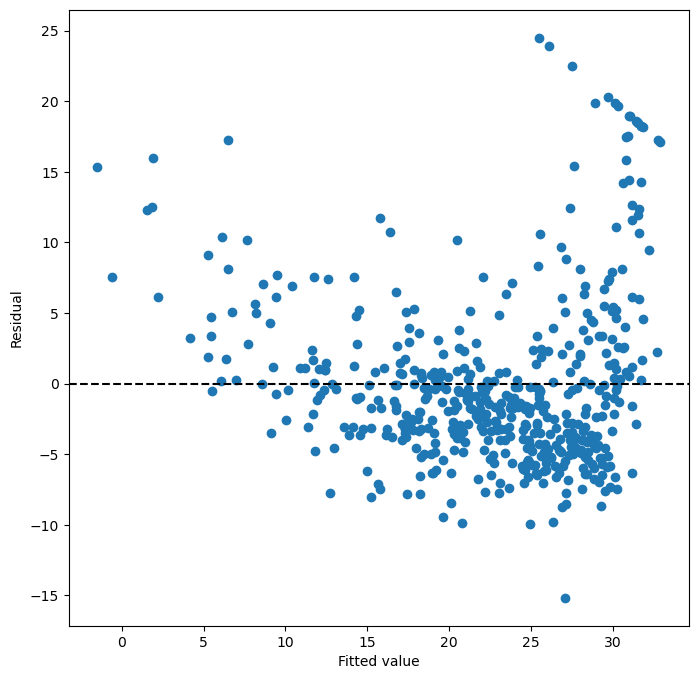

In [43]:
# Create a residual plot
ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues , results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

The residual plot shows non-constant varianec of the error terms, which suggests that the relationship in the data might not be linear.

We can plot the leverage of of each data point for our predictor:

374

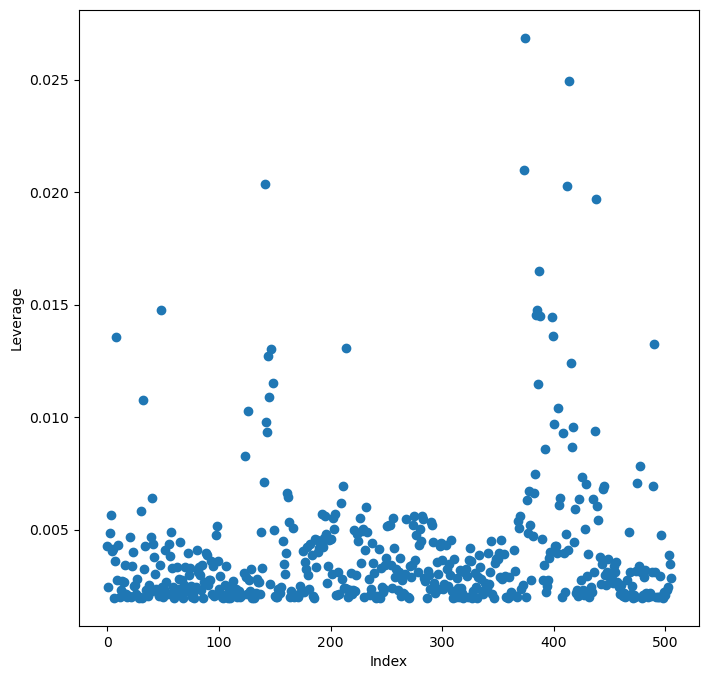

In [44]:
infl = results.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

#### 3.6.3 Multiple Linear Regression

In order to fit a multiple linear regression model using least squares, we again use the `ModelSpec()` transform to construct the required model matrix and response. The arguments to We consider a fit here with the two variables: `lstat` and `age`.

In [62]:
X = MS(['lstat', 'age']).fit_transform(Boston)
model1 = sm.OLS(y, X)
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           2.98e-88
Time:                        12:58:04   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     33.2228      0.731     45.458      0.000      31.787      34.659
lstat         -1.0321      0.048    -21.416      0.000      -1.127      -0.937
age            0.0345      0.012      2.826      0.005       0.011       0.059
==============================================================================
Omnibus:                      124.288   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.026
Skew:                           1.362   Prob(JB):                     1.02e-53
Kurtosis:                       5.038   Cond. No.                         201.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
terms = Boston.columns.drop('medv')
terms

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat'],
      dtype='object')

In [54]:
# Fit a model containing every possible predictor
X = MS(terms).fit_transform(Boston)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          2.23e-133
Time:                        12:36:35   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     41.6173      4.936      8.431      0.000      31.919      51.316
crim          -0.1214      0.033     -3.678      0.000      -0.186      -0.057
zn             0.0470      0.014      3.384      0.001       0.020       0.074
indus          0.0135      0.062      0.217      0.829      -0.109       0.136
chas           2.8400      0.870      3.264      0.001       1.131       4.549
nox          -18.7580      3.851     -4.870      0.000     -26.325     -11.191
rm             3.6581      0.420      8.705      0.000       2.832       4.484
age            0.0036      0.013      0.271      0.787      -0.023       0.030
dis           -1.4908      0.202     -7.394      0.000      -1.887      -1.095
rad            0.2894      0.067      4.325      0.000       0.158       0.421
tax           -0.0127      0.004     -3.337      0.001      -0.020      -0.005
ptratio       -0.9375      0.132     -7.091      0.000      -1.197      -0.678
lstat         -0.5520      0.051    -10.897      0.000      -0.652      -0.452
==============================================================================
Omnibus:                      171.096   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              709.937
Skew:                           1.477   Prob(JB):                    6.90e-155
Kurtosis:                       7.995   Cond. No.                     1.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
# Fit a model containing every predictor except for age:
minus_age = Boston.columns.drop(['medv', 'age'])
Xma = MS(minus_age).fit_transform(Boston)
model1 = sm.OLS(y, Xma)
model1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     124.1
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          2.03e-134
Time:                        12:36:36   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3034.
Df Residuals:                     494   BIC:                             3085.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     41.5251      4.920      8.441      0.000      31.859      51.191
crim          -0.1214      0.033     -3.683      0.000      -0.186      -0.057
zn             0.0465      0.014      3.379      0.001       0.019       0.074
indus          0.0135      0.062      0.217      0.829      -0.109       0.135
chas           2.8528      0.868      3.287      0.001       1.148       4.558
nox          -18.4851      3.714     -4.978      0.000     -25.782     -11.188
rm             3.6811      0.411      8.951      0.000       2.873       4.489
dis           -1.5068      0.193     -7.825      0.000      -1.885      -1.128
rad            0.2879      0.067      4.322      0.000       0.157       0.419
tax           -0.0127      0.004     -3.333      0.001      -0.020      -0.005
ptratio       -0.9346      0.132     -7.099      0.000      -1.193      -0.676
lstat         -0.5474      0.048    -11.483      0.000      -0.641      -0.454
==============================================================================
Omnibus:                      172.506   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              724.941
Skew:                           1.485   Prob(JB):                    3.81e-158
Kurtosis:                       8.056   Cond. No.                     1.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A good way to assess multi-collinearity is the _Variance Inflation Factor_. The VIF is the ratio of the variance of a predictor coefficient when fitting the full model divided by the variance of the predictor coefficient if fit on its own.

In [58]:
# Compute the VIFs for each predictor:
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals}, index = X.columns[1:])
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity. None of our VIFs here are that large.

We can include interaction terms in the model by using a tuple in the model matrix builder:

In [59]:
# Fit model with interaction term between lstat and age:
X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
summarize(model2.fit())

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


The model matrix builder can include terms representing polynomial functions:

In [60]:
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


The effectively zero p-value associated with the quadratic term (i.e. the third row above) suggests that it leads to an improved model.

We can quantify the extent to which non-linear model is superior by performing a hypothesis test comparing the two models using `anova_lm()`. The null hypothesis is that the quadratic term in the bigger model is not needed, and the alternative hypothesis is that the bigger model is superior.

In [63]:
anova_lm(results1, results3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


Here, the F-statistic is the t-statistic of the quadratic term in the model summary for `results3`. This provides clear evidence that the quadratic polynomial in `lstat` improves the model.

#### 3.6.7 Qualitative Predictors

Here we use the `Carseats` data, which is included in the `ISLP` package. We will attempt to predict `Sales` (child car seat sales) in 400 locations based on a number of predictors.

In [64]:
Carseats = load_data('Carseats')
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

The predictor `ShelveLoc` can take on three possible values: `Bad`, `Medium`, `Good`.

We fit a multiple regression model that includes some interaction terms:

In [66]:
 allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
final = allvars + [('Income', 'Advertising'),
('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288


A bad shelving location corresponds to a zero for each of the two dummy variables. The fact that the coefficient for `ShelveLoc[Good]` in the regression output is positive indicates that a good shelving location is associated with high sales (relative to a bad location). `And ShelveLoc[Medium]` has a smaller positive coefficient, indicating that a medium shelving location leads to higher sales than a bad shelving location, but lower sales than a good shelving location.